Weights already downloaded


/teamspace/studios/this_studio/Human-pose-as-compositional-tokens/process/data.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image, dtype=torch.float32),


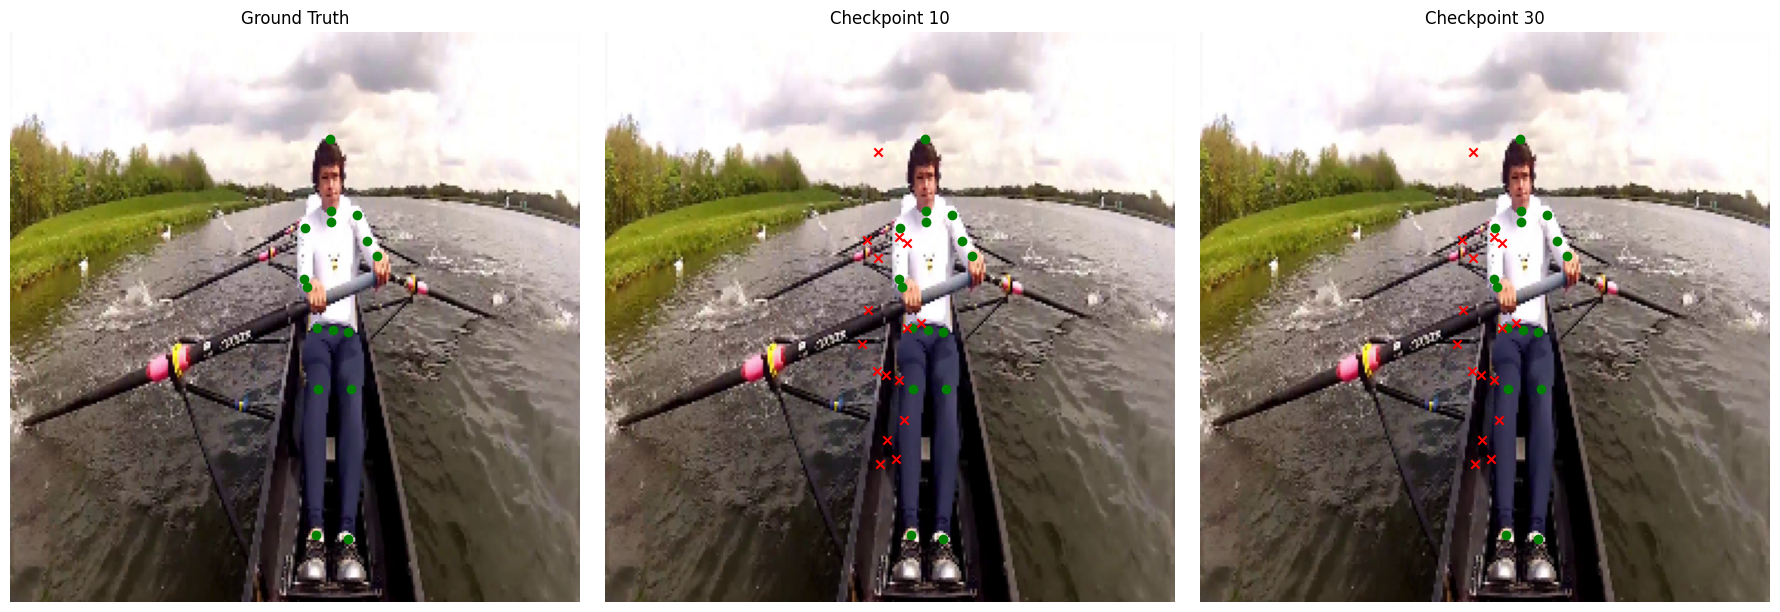

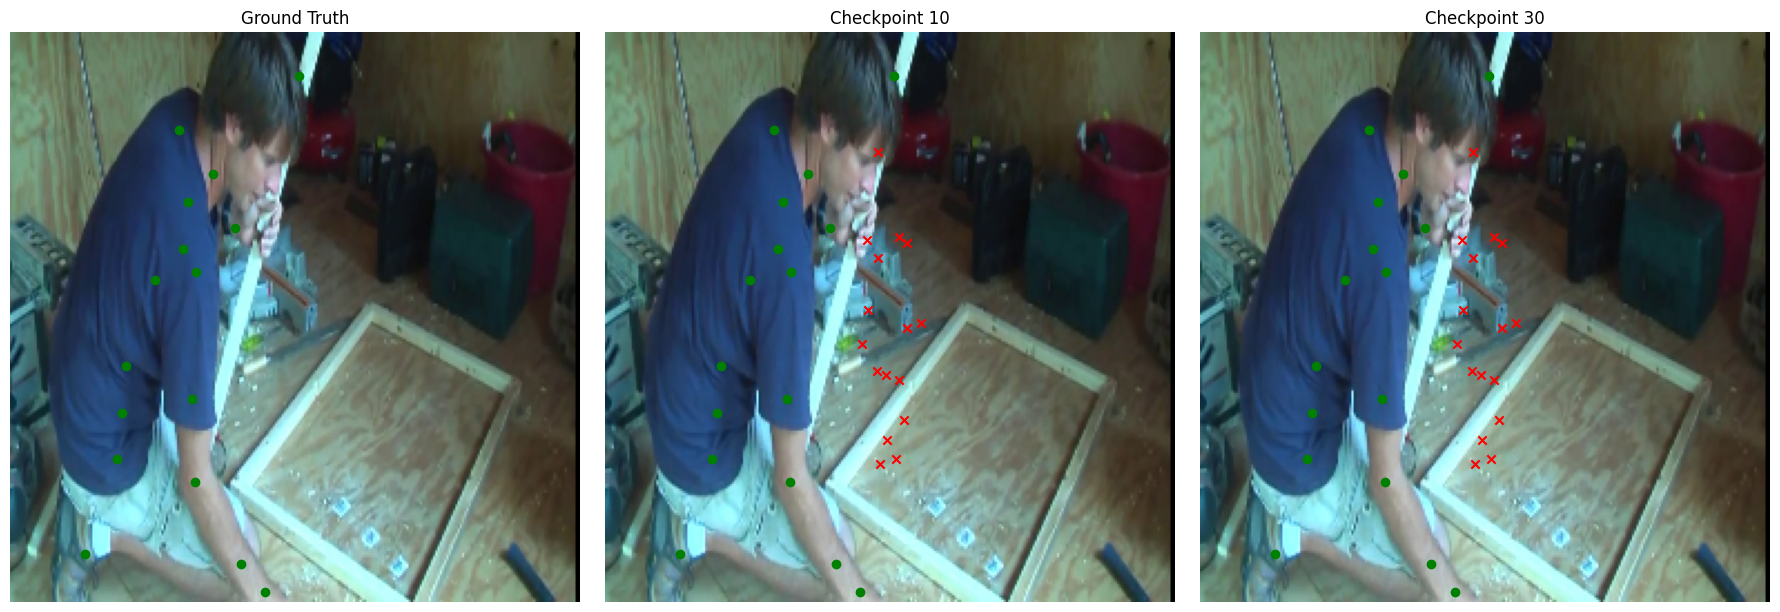

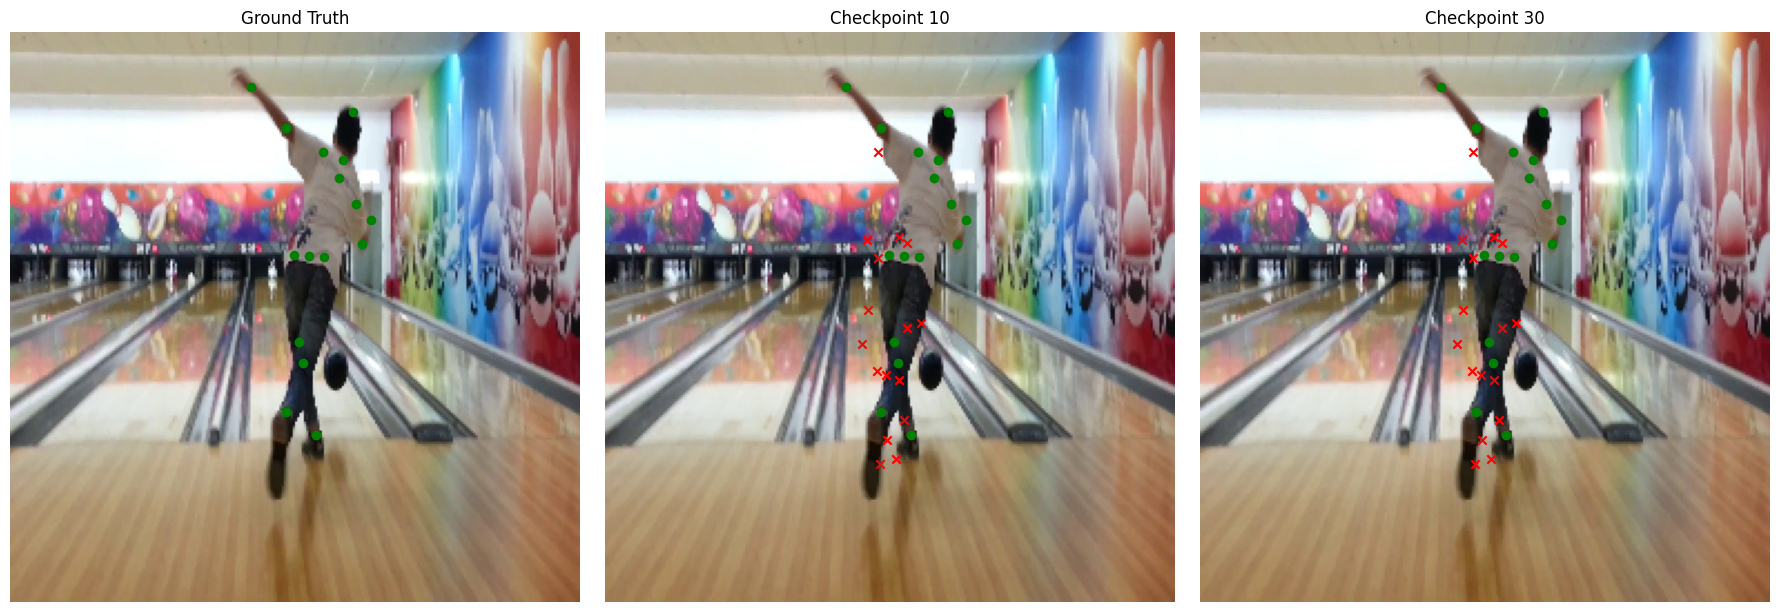

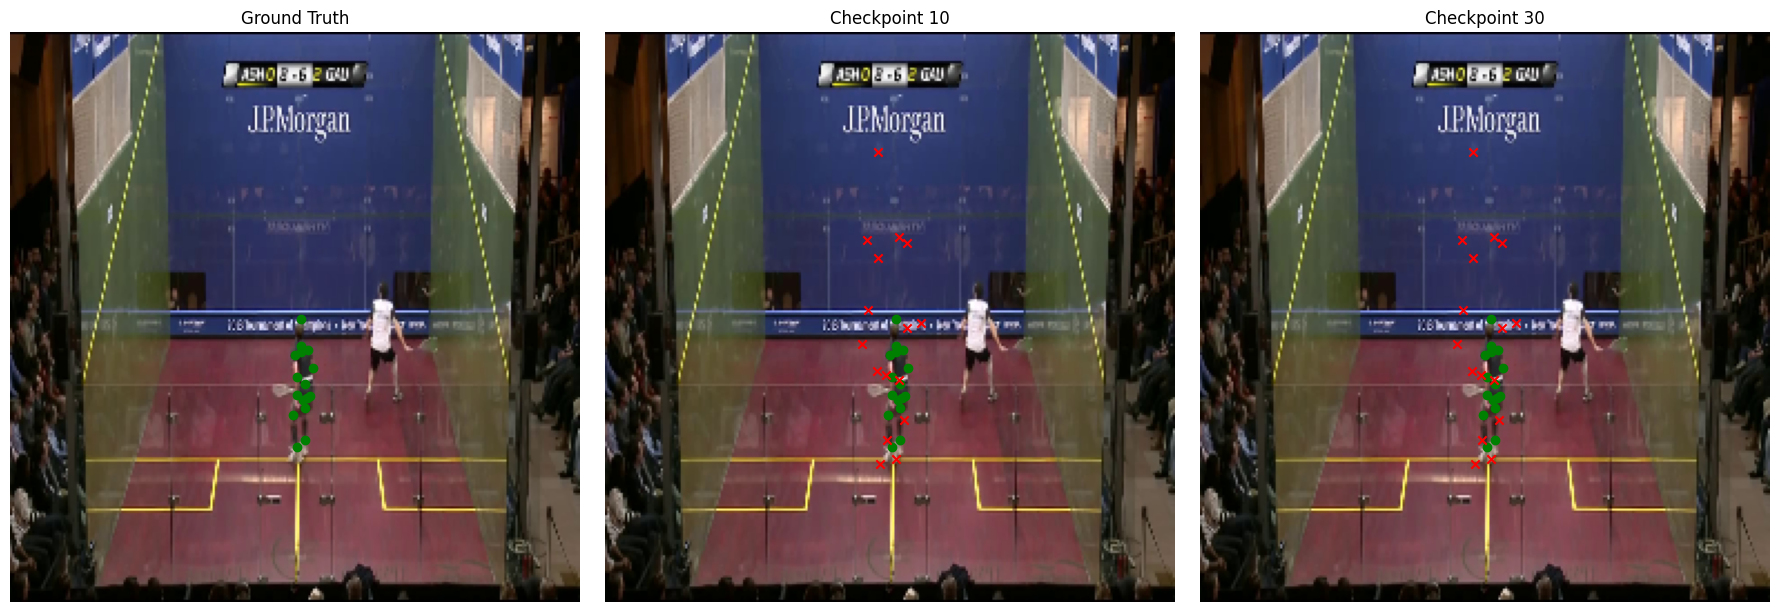

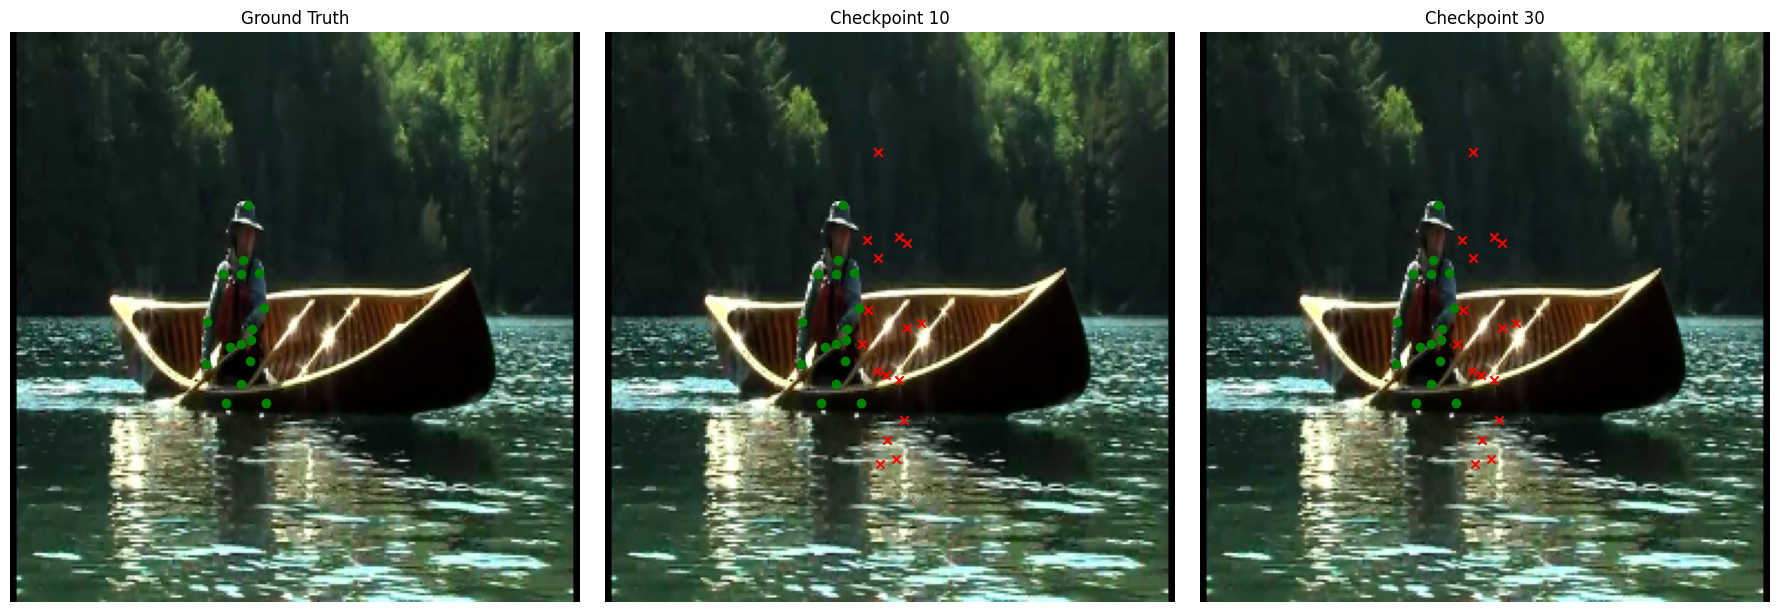

In [7]:
import os
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from model.encoder import CompositionalEncoder, ClassificationHead, Decoder, VectorQuantizer
from process.data import MPIIDataset
from api.models import load_decoder_and_quantizer_weights
import timm
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# CONFIGURATION
# -----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

NUM_JOINTS = 16
DIMENSION = 2
HIDDEN_DIM = 256
m = 16
IMAGE_SIZE = 256
IMAGE_DIR = './images/'
CSV_PATH = './mpii_human_pose_v1_u12_2/mpii_human_pose.csv'
CHECKPOINT_PATH = './ckpt/stage 2/classification_head_10.pt'  # Change if needed

# -----------------------------
# DATASET AND TRANSFORMS
# -----------------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])
dataset = MPIIDataset(CSV_PATH, IMAGE_DIR, transform, augment=False)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# -----------------------------
# MODEL LOADING
# -----------------------------
load_decoder_and_quantizer_weights()
encoder_weights = torch.load(os.path.join(os.getcwd(), 'weights', '50.pt'), map_location=device)

encoder = CompositionalEncoder(k=NUM_JOINTS, d=DIMENSION, h=HIDDEN_DIM, m=m).to(device)
encoder.load_state_dict(encoder_weights['encoder'])

vq = VectorQuantizer(v=2*HIDDEN_DIM, h=HIDDEN_DIM, commitment_cost=0.25).to(device)
vq.load_state_dict(encoder_weights['quantizer'])

decoder = Decoder(k=NUM_JOINTS, d=DIMENSION, h=HIDDEN_DIM, m=m).to(device)
decoder.load_state_dict(encoder_weights['decoder'])

backbone = timm.create_model('swinv2_base_window12to16_192to256.ms_in22k_ft_in1k', pretrained=True)
backbone.to(device)
backbone.eval()

head = ClassificationHead(
    in_channels=1024,
    num_tokens=16,
    token_dim=256,
    codebook_size=512
).to(device)

# Load Classification Head Weights
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
head.load_state_dict(checkpoint['classification_head'])

# Set to eval mode
encoder.eval()
vq.eval()
decoder.eval()
head.eval()

# -----------------------------
# INFERENCE + VISUALIZATION
# -----------------------------
def plot_keypoints_comparison(img_tensor, true_kpts, pred_kpts_list, titles):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    true_kpts = true_kpts.cpu().numpy() * 256
    num_versions = len(pred_kpts_list)

    fig, axs = plt.subplots(1, num_versions + 1, figsize=(6 * (num_versions + 1), 6))

    # Plot original image with GT
    axs[0].imshow(img)
    axs[0].scatter(true_kpts[:, 0], true_kpts[:, 1], color='green', label='Ground Truth')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    for i, pred_kpts in enumerate(pred_kpts_list):
        pred_kpts = pred_kpts.cpu().numpy() * 256
        axs[i + 1].imshow(img)
        axs[i + 1].scatter(true_kpts[:, 0], true_kpts[:, 1], color='green', label='GT')
        axs[i + 1].scatter(pred_kpts[:, 0], pred_kpts[:, 1], color='red', marker='x', label='Pred')
        axs[i + 1].set_title(titles[i])
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


# --------------------------
# Load both checkpoints
# --------------------------
checkpoint_paths = [
    './ckpt/stage 2/classification_head_10.pt',
    './ckpt/stage 2/classification_head_30.pt'
]
titles = ["Checkpoint 10", "Checkpoint 30"]

heads = []
for path in checkpoint_paths:
    head_model = ClassificationHead(
        in_channels=1024,
        num_tokens=16,
        token_dim=256,
        codebook_size=512
    ).to(device)
    checkpoint = torch.load(path, map_location=device)
    head_model.load_state_dict(checkpoint['classification_head'])
    head_model.eval()
    heads.append(head_model)

# -----------------------------
# Inference loop
# -----------------------------
with torch.no_grad():
    for idx, (image, true_poses, _) in enumerate(loader):
        image, true_poses = image.to(device), true_poses.to(device)

        features = backbone.forward_features(image)

        pred_keypoints = []
        for head_model in heads:
            logits = head_model(features)
            probs = torch.softmax(logits, dim=-1)             # (B, M, V)
            s = torch.matmul(probs, vq.codebook.detach())     # (B, M, H)
            pred_pose = decoder(s)                            # (B, M, D)
            pred_keypoints.append(pred_pose[0])

        plot_keypoints_comparison(image[0], true_poses[0], pred_keypoints, titles)

        if idx == 4:  # visualize 5 samples max
            break
